In [1]:
%%HTML
<!--NOTE: Only required for export to Anaconda.org--!>
<link rel="stylesheet" href="https://d2lno7p4w2n6kz.cloudfront.net/bootstrap.anaconda.css">
<link rel="stylesheet" href="https://code.jquery.com/ui/1.10.4/themes/smoothness/jquery-ui.css">

# Mapping Stations

In [2]:
import datetime as dt

import numpy as np
import pandas as pd
import holoviews as hv

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
hv.notebook_extension("bokeh", inline=True, width=95)

In [4]:
import param

from holoviews import Element2D
from holoviews.plotting.bokeh.element import ElementPlot

class MapTiles(Element2D):
    
    group = param.String(default='MapTiles')
    
    def dimension_values(self, dim):
        return []

    def range(self, dim):
        return np.NaN, np.NaN

class TilePlot(ElementPlot):
    
    styl_opts = ['alpha', 'render_parents']
    
    def get_data(self, element, ranges=None, empty=False):
        return {}, {'tile_source': element.data}
    
    def _init_glyph(self, plot, mapping, properties):
        """
        Returns a Bokeh glyph object.
        """
        renderer = plot.add_tile(mapping['tile_source'])
        return renderer, renderer
        
hv.Store.register({MapTiles: TilePlot}, 'bokeh')
options = hv.Store.options(backend='bokeh')

options.MapTiles = hv.Options('plot', xaxis=None, yaxis=None)

def toWebMercator(xLon, yLat):
    # Check if coordinate out of range for Latitude/Longitude
    semimajorAxis = 6378137.0  # WGS84 spheriod semimajor axis
    east = xLon * 0.017453292519943295
    north = yLat * 0.017453292519943295
 
    northing = 3189068.5 * np.log((1.0 + np.sin(north)) / (1.0 - np.sin(north)))
    easting = semimajorAxis * east
 
    return easting, northing

In [68]:
df=pd.read_csv("Dades/OUTPUT XX Filtered Stations Urban-No Urban.csv")
dates=pd.DataFrame(columns=["Station ID", "minDate", "maxDate", "Period"])
df2=pd.read_csv("Dades/OUTPUT 01 Filtered Dades Peninsula.csv")

In [69]:
def dateyear(x):
    year=int(x)
    month=int((x-year)*12+0.5)
    date=str(month)+"/"+str(year)
    return date
def period(x):
    year=int(x)
    month=int((x-year)*12+0.5)
    time=str(year)+" Y "+str(month)+" M"
    return time

In [70]:

for i in df2["Station ID"].unique():
    T=df2[df2["Station ID"]==i]
    fila=pd.DataFrame([[i, T["Date"].min(), T["Date"].max(), T["Date"].max()-T["Date"].min()]], 
                      columns=["Station ID", "minDate", "maxDate", "Period"])
    dates=dates.append(fila, ignore_index=True)
dates=dates.set_index("Station ID")
dates["Period2"]=0
for i in dates.index:
    dates["minDate"][i]=dateyear(dates["minDate"][i])
    dates["maxDate"][i]=dateyear(dates["maxDate"][i])
    dates["Period2"][i]=period(dates["Period"][i])
dates.head()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,minDate,maxDate,Period,Period2
Station ID,,,,
275,1/1951,11/1970,19.916,19 Y 11 M
285,8/2000,8/2013,13.000,13 Y 0 M
14653,1/1938,11/1947,9.916,9 Y 11 M
14654,8/1911,11/1934,23.333,23 Y 4 M
14655,1/1900,11/1937,37.916,37 Y 11 M


In [76]:
def perbin(x):
    if x<10:
        t="<10"
    elif x<20 and x>=10:
        t="<20"
    elif x>=20 and x<30:
        t="<30"
    elif x>=30:
        t=">30"
    return t
dates["Period_r"]=0
for i in dates.index:
    dates["Period_r"][i]=perbin(dates["Period"][i])
dates.head()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,minDate,maxDate,Period,Period2,Period_r
Station ID,,,,,
275,1/1951,11/1970,19.916,19 Y 11 M,<20
285,8/2000,8/2013,13.000,13 Y 0 M,<20
14653,1/1938,11/1947,9.916,9 Y 11 M,<10
14654,8/1911,11/1934,23.333,23 Y 4 M,<30
14655,1/1900,11/1937,37.916,37 Y 11 M,>30


In [8]:
df["First Record"]=df["Station ID"].map(dates.minDate)
df["Last Record"]=df["Station ID"].map(dates.maxDate)
df["Period"]=df["Station ID"].map(dates.Period)
df["Type"]=df.isUrban
df["St"]=df.isUrban

for i in df.index:
    if df["isUrban"][i]==1:
        df["Type"][i]="Urban"
    else:
        df["Type"][i]="Rural"
for i in df.index:
    df["St"]=float(1)
df.head()
df=df.fillna("No Data")

xs, ys = toWebMercator(df['Longitude'], df['Latitude'])
df['x'] = xs
df['y'] = ys

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


When you overlay multiple Elements their color is drawn from the color style option. You can specify a Palette to draw the colors from which support all standard matplotlib color maps:

In [9]:
%output size=150
%opts Overlay [width=800 height=800]
%opts Points.Stations [tools=['hover'] color_index=None size_index=None] (color=Palette('Set1') size=10)
%opts Polygons.Continents (color='k')
%opts Contours.Countries (color='white')

Points cannot currently be directly colored by categorical or string values. Instead to achieve this put your DataFrame inside a Table and then use the ``.to`` methods to convert to the appropriate type. Here you may specify the key dimensions, value dimensions and map dimensions. To group and overlay the stations by their Type specify `Type` as a map dimension (using ``mdims``) and then overlay that dimension:

In [10]:
from bokeh.tile_providers import STAMEN_TONER, STAMEN_TERRAIN
from bokeh.models import WMTSTileSource

openmap_url = 'http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'
otile_url = 'http://otile1.mqcdn.com/tiles/1.0.0/sat/{Z}/{X}/{Y}.jpg'

OTILE = WMTSTileSource(url=otile_url)
OPENMAP = WMTSTileSource(url=openmap_url)

lon_w=-9.536133
lon_e=3.076172
lat_s=35.995785
lat_n=43.961191

l, b = toWebMercator(lon_w, lat_s)
r, t = toWebMercator(lon_e, lat_n)
extents = (l, b, r, t)
tiles = MapTiles(OTILE, extents=extents)

In [11]:
%opts Overlay [xaxis=None yaxis=None]
df['Station_Name'] = df['Station Name']
table = hv.Table(df)
points_by_urbanization = tiles * table.to.points(kdims=["x","y"], vdims=['Station_Name', 'Latitude', 'Longitude'],
                                                 mdims=['Type'], group='Stations').overlay()
points_by_urbanization

C:\Anaconda2\lib\site-packages\bokeh\plotting\helpers.py:290: UserWarning: HoverTool are being repeated
  warnings.warn("%s are being repeated" % ",".join(repeated_tools))


:Overlay
   .MapTiles.I :MapTiles
   .Stations.I :NdOverlay   [Type]
      :Points   [x,y]   (Station_Name,Latitude,Longitude)

In [12]:
tiles * table.to.points(kdims=["x","y"], vdims=['Station_Name', 'Latitude', 'Longitude'],
                        mdims=['Country'], group='Stations').overlay()

:Overlay
   .MapTiles.I :MapTiles
   .Stations.I :NdOverlay   [Country]
      :Points   [x,y]   (Station_Name,Latitude,Longitude)

To get access to the HTML you can use the Renderer directly by looking it up on the store:

In [13]:
renderer = hv.Store.renderers['bokeh']
html = renderer.html(points_by_urbanization)
with open('web/stationmap.html', 'w') as f:
    f.write(html)

# Mapping evolution

In [124]:
df_evol=pd.read_csv("Dades/OUTPUT 04 Dades Normalitzades.csv")
df_evol.head()
#change date type to YYYY-MM-DD format
df_evol['Year'] = df_evol.Year.astype(int)
df_evol['Month'] = df_evol.Month.astype(int)
df_evol['Date'] = [dt.datetime(int(row.Year), int(row.Month), 15) for i, row in df_evol.iterrows()]

In [125]:
l, b = toWebMercator(lon_w, lat_s)
r, t = toWebMercator(lon_e, lat_n)
extents = (l, b, r, t)
tiles = MapTiles(STAMEN_TONER, extents=extents)

In [126]:
#incorporate Lat Lon
dfST=df.set_index("Station ID")
df_evol["Latitude"]=df_evol["Station ID"].map(dfST["Latitude"])
df_evol["Longitude"]=df_evol["Station ID"].map(dfST["Longitude"])
df_evol["Day"]=15

xs, ys = toWebMercator(df_evol['Longitude'], df_evol['Latitude'])
df_evol['x'] = xs
df_evol['y'] = ys

In [98]:
df_evol.head()

,Date,Month,Station ID,Temperature (C),Temperature Norm,Temperature Norm Smoothed (ewma),Temperature Norm Smoothed (moving avg),Year,DateISO,Latitude,Longitude,Day,x,y
0,1951-01-15,1,275,10.2,0.39,0.390000,-0.91,1951,1951-01-01,39.6,2.7,15,300562.625142,4807984.493191
1,1952-01-15,1,275,8.8,-1.01,-0.485000,-0.96,1952,1952-01-01,39.6,2.7,15,300562.625142,4807984.493191
2,1953-01-15,1,275,7.7,-2.11,-1.314082,-0.17,1953,1953-01-01,39.6,2.7,15,300562.625142,4807984.493191
3,1954-01-15,1,275,8.7,-1.11,-1.220294,-0.17,1954,1954-01-01,39.6,2.7,15,300562.625142,4807984.493191
4,1955-01-15,1,275,12.8,2.99,0.605822,-0.39,1955,1955-01-01,39.6,2.7,15,300562.625142,4807984.493191


If you just want to explore a dataset without exporting it you can set the widget mode to live, this means the frames are generated as you update the plot. However for very large datasets you may find it better to use a DynamicMap.


Your color issue arose because the color_index and size_index are indexed from zero as is convention in Python, note that you can also supply the actual name of the dimension you want to color by, here 2 and 'Temperature Norm' are equivalent:

In [18]:
evol_table = hv.Table(df_evol, kdims=['Year', 'Month', 'Day', 'Date', 'x', 'y'])

In [19]:
%opts Points.Stations [color_index=2] (size=15 line_width=3 line_color='black' cmap="coolwarm")

In [20]:
%%opts Overlay [width=600 height=600]
year_table = evol_table.aggregate(['Year', 'x', 'y'], np.max)
year_points = year_table.to.points(['x', 'y'], ['Temperature (C)', 'Station ID'], ['Year'], group='Stations')
(tiles * year_points).hist(index=1)

ValueError: Out of range float values are not JSON compliant: -inf

:AdjointLayout
   :HoloMap   [Year]
      :Overlay
         .MapTiles.I :MapTiles
         .Stations.I :Points   [x,y]   (Temperature (C),Station ID)
   :HoloMap   [Year]
      :Histogram   [Temperature (C)]   (Frequency)

In [ ]:
%%output max_frames=2000
%%opts Overlay [width=600 height=600]
month_table = evol_table.aggregate(['Year', 'Month', 'x', 'y'], np.max)
month_points = month_table.to.points(['x', 'y'], ['Temperature (C)', 'Station ID'],
                                     ['Year', 'Month'], group='Stations')

# Adds date column to table if scrubber widget 
# dates = ['%s-%s' % (y, m) for y, m in zip(month_table['Year'], month_table['Month'])]
# month_table = month_table.add_dimension('Date', 2, dates)
(tiles * month_points[2000:]).hist(index=1)

In [127]:
from scipy import stats
df_evol["DateISO"]=df_evol["Date"]
df_evol['years_since'] = pd.to_numeric((pd.to_datetime('1900-01-15')-df_evol.Date ).astype('timedelta64[Y]'))


In [128]:
df_evol["Period"]=df_evol["Station ID"].map(dates.Period_r)
df_evol.to_csv("Dades/OUTPUT 05 evolution stations.csv")
df_evol.head()

,Date,Month,Station ID,Temperature (C),Temperature Norm,Temperature Norm Smoothed (ewma),Temperature Norm Smoothed (moving avg),Year,DateISO,Latitude,Longitude,Day,x,y,years_since,Period
0,1951-01-15,1,275,10.2,0.39,0.390000,-0.91,1951,1951-01-15,39.6,2.7,15,300562.625142,4.001965e-315,-51,<20
1,1952-01-15,1,275,8.8,-1.01,-0.485000,-0.96,1952,1952-01-15,39.6,2.7,15,300562.625142,3.232303e-315,-52,<20
2,1953-01-15,1,275,7.7,-2.11,-1.314082,-0.17,1953,1953-01-15,39.6,2.7,15,300562.625142,3.045095e-315,-54,<20
3,1954-01-15,1,275,8.7,-1.11,-1.220294,-0.17,1954,1954-01-15,39.6,2.7,15,300562.625142,3.045111e-315,-54,<20
4,1955-01-15,1,275,12.8,2.99,0.605822,-0.39,1955,1955-01-15,39.6,2.7,15,300562.625142,3.045104e-315,-55,<20


In [129]:

df_evol.dtypes

Date                                      datetime64[ns]
Month                                              int32
Station ID                                       float64
Temperature (C)                                  float64
Temperature Norm                                 float64
Temperature Norm Smoothed (ewma)                 float64
Temperature Norm Smoothed (moving avg)           float64
Year                                               int32
DateISO                                   datetime64[ns]
Latitude                                         float64
Longitude                                        float64
Day                                                int64
x                                                float64
y                                                float64
years_since                                      float64
Period                                            object
dtype: object

In [132]:
df_evol=df_evol.dropna()
def linreg(df, xcol,  ycol):
    return stats.linregress(df[xcol], df[ycol]).slope()
df_evol["slope"]=0
df_evol["slope"]=df_evol["Station ID"].map(df_evol.groupby("Station ID").apply(lambda x: stats.linregress(x["years_since"],x["Temperature Norm"]).slope))


In [137]:
df_evol.head()

,Date,Month,Station ID,Temperature (C),Temperature Norm,Temperature Norm Smoothed (ewma),Temperature Norm Smoothed (moving avg),Year,DateISO,Latitude,Longitude,Day,x,y,years_since,Period,slope
0,1951-01-15,1,275,10.2,0.39,0.390000,-0.91,1951,1951-01-15,39.6,2.7,15,300562.625142,4.001965e-315,-51,<20,-0.015716
1,1952-01-15,1,275,8.8,-1.01,-0.485000,-0.96,1952,1952-01-15,39.6,2.7,15,300562.625142,3.232303e-315,-52,<20,-0.015716
2,1953-01-15,1,275,7.7,-2.11,-1.314082,-0.17,1953,1953-01-15,39.6,2.7,15,300562.625142,3.045095e-315,-54,<20,-0.015716
3,1954-01-15,1,275,8.7,-1.11,-1.220294,-0.17,1954,1954-01-15,39.6,2.7,15,300562.625142,3.045111e-315,-54,<20,-0.015716
4,1955-01-15,1,275,12.8,2.99,0.605822,-0.39,1955,1955-01-15,39.6,2.7,15,300562.625142,3.045104e-315,-55,<20,-0.015716


In [140]:
merged_df = df_evol.merge(table.data.filter(['Station ID', 'Country', 'Type']))
merged_table = hv.Table(merged_df, kdims=['Year', 'Month', 'Country', 'Type', 'Date',"DateISO","years_since","slope","Period"])

In [59]:
merged_table.aggregate(["DateISO"],np.mean,np.std).data

,DateISO,Station ID,Temperature (C),Temperature Norm,Temperature Norm Smoothed (ewma),Temperature Norm Smoothed (moving avg),Latitude,Longitude,Day,x,...,Station ID_std,Temperature (C)_std,Temperature Norm_std,Temperature Norm Smoothed (ewma)_std,Temperature Norm Smoothed (moving avg)_std,Latitude_std,Longitude_std,Day_std,x_std,y_std
0,1951-01-15,111243.924528,7.886792,-0.149926,-0.142942,-0.866124,40.026985,-3.204155,15,-356684.892521,...,65738.906142,3.059078,0.503223,0.396023,0.441510,2.063419,3.452759,0,384359.349246,NaN
1,1952-01-15,110358.981132,6.296604,-1.804464,-0.967781,-1.281737,40.095831,-3.111096,15,-346325.584722,...,65730.899427,3.212719,0.672894,0.525271,0.466388,2.181359,3.465608,0,385789.664417,NaN
2,1953-01-15,108391.169492,6.221068,-1.709684,-1.278284,-0.547210,40.126727,-3.060633,15,-340708.131593,...,66244.903291,3.447966,0.825174,0.529758,0.427598,2.131749,3.381432,0,376419.318643,NaN
3,1954-01-15,111392.842105,6.105439,-1.898944,-1.596827,-0.386128,40.137964,-3.060741,15,-340720.154959,...,65379.919743,3.327003,0.585610,0.554159,0.476753,2.174629,3.414274,0,380075.229011,NaN
4,1955-01-15,109213.116667,10.590733,2.755785,0.379663,-0.394745,40.101492,-3.168653,15,-352732.857014,...,65983.463646,3.266616,0.722185,0.416835,0.358318,2.103913,3.455538,0,384668.763223,NaN
5,1956-01-15,108529.559322,8.476831,0.614826,0.432855,-0.140893,40.155640,-3.028333,15,-337112.512040,...,66355.557827,3.196964,0.536765,0.396758,0.419517,2.135645,3.338901,0,371684.793543,NaN
6,1957-01-15,106910.892308,5.856769,-2.091183,-0.758383,0.263403,40.068936,-3.214976,15,-357889.439854,...,66721.299591,3.519543,0.768643,0.572705,0.550668,2.196294,3.249129,0,361691.359869,NaN
7,1958-01-15,109987.636364,7.789152,-0.153958,-0.428893,-0.129668,40.051428,-3.250108,15,-361800.354090,...,66137.479708,3.077043,0.523238,0.421672,0.420960,2.153629,3.340596,0,371873.480356,NaN
8,1959-01-15,112100.301587,9.128778,1.022151,0.215028,-0.299579,40.027402,-3.191026,15,-355223.339953,...,65663.080161,3.086338,0.758809,0.479884,0.417684,2.130764,3.415048,0,380161.422181,NaN
9,1960-01-15,112854.970149,7.737358,-0.021482,0.093171,0.264300,40.211182,-3.356735,15,-373669.989391,...,65334.222779,3.025293,0.417490,0.368556,0.419905,2.129242,3.315553,0,369085.643216,NaN


In [159]:
%%opts Overlay [width=1200 height=400 xaxis='bottom' yaxis='left'] 
%%opts Spread (fill_alpha=0.2 line_alpha=0 fill_color='black')
%%opts Curve (line_width=0.5 color='black') 
aggregate = merged_table.aggregate(['DateISO'], np.mean, np.std)
plot=aggregate.to.spread('DateISO', ['Temperature Norm', 'Temperature Norm_std']) * aggregate.to.curve('DateISO', ['Temperature Norm'])
renderer = hv.Store.renderers['bokeh']
html = renderer.html(plot)
with open('web/05_Temp_Date.html', 'w') as f:
    f.write(html)

In [157]:
%%opts Overlay [width=1000 height=400 xaxis='bottom' yaxis='left'] 
%%opts Curve (line_width=0.5 color='black') 
%%opts Spread (fill_alpha=0.2 line_alpha=0.5 fill_color='black')
aggregate = merged_table.aggregate(['Year'], np.mean, stats.sem)
plot=aggregate.to.spread('Year', ['Temperature Norm', 'Temperature Norm_sem']) * aggregate.to.curve('Year', ["Temperature Norm"])
renderer = hv.Store.renderers['bokeh']
html = renderer.html(plot)
with open('web/05_TempNorm_Year.html', 'w') as f:
    f.write(html)

In [158]:
%%opts Overlay [width=1000 height=400 xaxis='bottom' yaxis='left'] 
%%opts Spread (fill_alpha=0.2 line_alpha=0)
aggregate = merged_table.aggregate(['Year', 'Type'], np.mean, stats.sem)
plot=aggregate.to.spread('Year', ['Temperature Norm', 'Temperature Norm_sem']).overlay() * aggregate.to.curve('Year', ['Temperature Norm']).overlay()
renderer = hv.Store.renderers['bokeh']
html = renderer.html(plot)
with open('web/05_TempRurUrb_Year.html', 'w') as f:
    f.write(html)

:BoxWhisker   [Year]   (Temperature Norm)
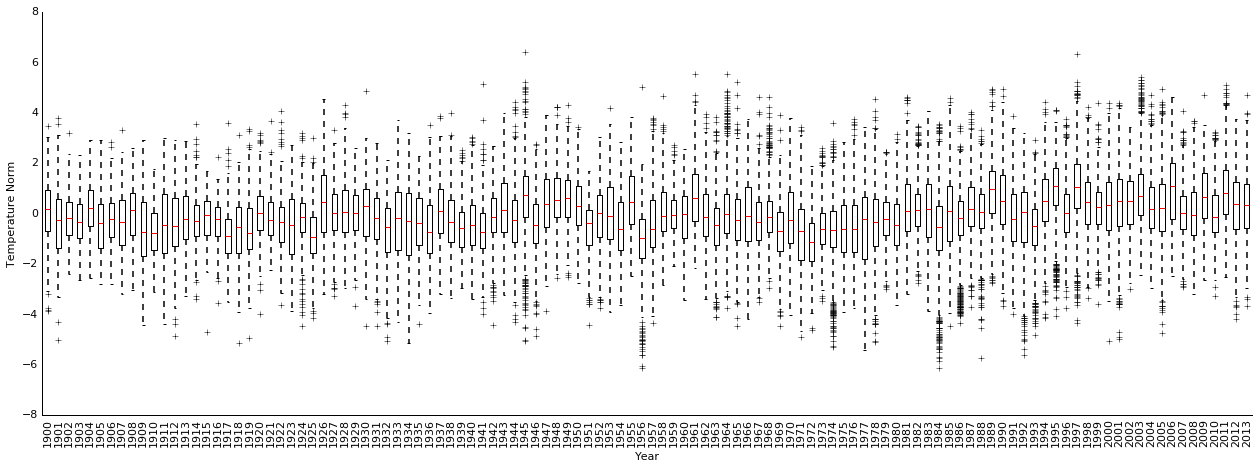

In [51]:
%%output backend='matplotlib' size=600
%%opts BoxWhisker [aspect=3 bgcolor='w' xrotation=90 show_frame=False] (boxprops=dict(linewidth=1, color='k'))
merged_table.to.box('Year', 'Temperature Norm', []).sort()

In [153]:
%%opts Bars [width=1000 stack_index=1 show_legend=True] (color=["DimGrey","CornFlowerBlue"])
plot=hv.Bars(merged_df.groupby(['Type', 'Year']).aggregate('count').reset_index(), kdims=['Year', 'Type'], vdims=['Station ID'])
renderer = hv.Store.renderers['bokeh']
html = renderer.html(plot)
with open('web/05_stationCount.html', 'w') as f:
    f.write(html)

In [160]:
%%opts NdOverlay [width=1000] Histogram (fill_color=Cycle() fill_alpha=0.3)
plot=hv.operation.histogram(merged_table.groupby('Period'), adjoin=False,
                       dimension='slope', bin_range=(-0.5, 0.5), num_bins=50).overlay().relabel(group='Distributions')
renderer = hv.Store.renderers['bokeh']
html = renderer.html(plot)
with open('web/05_Histogram.html', 'w') as f:
    f.write(html)

In [ ]:
%%opts NdOverlay [width=800] Histogram (fill_color=Cycle() fill_alpha=0.5)
hv.operation.histogram(merged_table.groupby('Type'), adjoin=False,
                       dimension='Temperature (C)', bin_range=(0, 30), num_bins=51).overlay().relabel(group='Distributions')

<IPython.core.display.Javascript object>


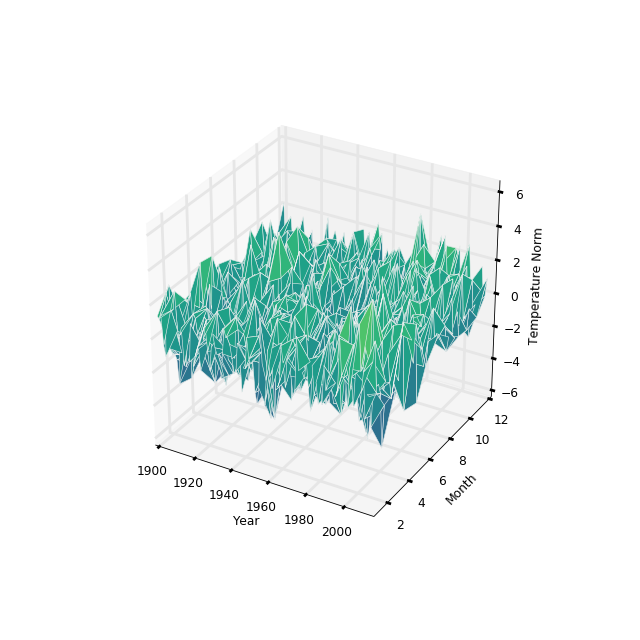

:Trisurface   [Year,Month]   (Temperature Norm)

In [54]:
%%output backend='matplotlib:nbagg' size=200 widgets='live'
%%opts Trisurface (cmap='viridis')
merged_table.to.trisurface(['Year', 'Month'], 'Temperature Norm', [])

In [ ]:
%%opts GridMatrix [width=800 height=800] NdOverlay [width=300 height=300]
%%opts Scatter (alpha=0.1)  Histogram (fill_color=Cycle() fill_alpha=0.3)
hv.operation.gridmatrix(hv.Table(merged_table, kdims=['Year', 'Quarter'],
                                 vdims=['Temperature (C)', 'Temperature Norm']).groupby('Quarter', container_type=hv.NdOverlay))